In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from scipy.stats import uniform, randint
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn import tree
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean

In [2]:
df_entrenar_all = pd.read_csv('modelado1_y.csv')
df_entrenar_all.drop('Unnamed: 0',axis=1, inplace=True)
df_entrenar_all = df_entrenar_all.set_index('pk_cid')

In [3]:
df_predicciones = pd.read_csv('predicciones.csv')
df_predicciones.drop('Unnamed: 0', axis = 1, inplace=True)
df_predicciones = df_predicciones.set_index('pk_cid')

In [4]:
def preparar_datos(producto_modelo):
    target = f'y_{producto_modelo}'
    filtro = f'{producto_modelo}_ANTE'
    df_entrenar = df_entrenar_all.copy()
    y_prev = df_entrenar[target] # sacamos y
    df_entrenar.drop(filtro, axis=1, inplace=True) # eliminamos la variable de filtro
    df_entrenar.drop(df_entrenar.columns[-10:], axis=1, inplace=True) # eliminamos los y-s
    df_entrenar.drop(borrar, axis=1, inplace=True) # eliminamos las varaibles que no nos queremos quedar
    df_entrenar.drop(producto_modelo, axis=1, inplace=True) # eliminamos el conteo de total de veces que ha contratado el producto y cada cliente
    df_entrenar = df_entrenar.drop_duplicates() # eliminamos duplicados
    X = df_entrenar # sacamos X
    z = X.merge(y_prev, how='inner', left_on= X.index, right_on=y_prev.index)
    y = z.set_index('key_0').iloc[:,-1]
    print('y.shape ' + str(y.shape)) # revisamos los shape
    print('X.shape ' + str(X.shape))
    print('Revisamos el balanceo')
    print(y.value_counts())
    return X,y, target, filtro

In [5]:
def modelos_Random_Search(X,y):
    models = {
    'decision_tree': [
        {
        "max_depth": np.arange(5, 40, 2),
        'min_samples_split': np.arange(2, 7, 2)
        }, 
        DecisionTreeClassifier(class_weight='balanced')
    ],
    'random_forest': [
        {
        'max_depth': np.arange(6, 15, 4),
        'n_estimators': np.arange(20, 100, 20),
        'min_samples_split': np.arange(2, 7, 2)
        }, 
        RandomForestClassifier(class_weight='balanced')
    ]
    }
    best_params = dict()
    best_score = dict()
    for model_name, l_model in models.items():
        print(model_name)
        params, model = l_model
        random_search = model_selection.RandomizedSearchCV(
            model, 
            param_distributions=params, 
            random_state=0, 
            n_iter=20, 
            cv=5, 
            verbose=1, 
            n_jobs=3, 
            return_train_score=True,
            scoring = 'precision'
        )
        random_search.fit(X, np.ravel(y))
        best_params[model_name] = random_search.best_params_
        best_score[model_name] = random_search.best_score_
    print(best_score) # imprimimos los resultados
    mejor_modelo = max(best_score, key=best_score.get) # nos quedamos con el modelo con mejores resultados
    print('Mejor modelo: ' + mejor_modelo)
    parametros_optimizados = best_params[mejor_modelo] # seleccionamos los hiperparametros
    print('Mejores hiperparametros: ' + str(parametros_optimizados))
    return mejor_modelo, parametros_optimizados


In [6]:
def entrenar_mejor_modelo(mejor_modelo, parametros_optimizados):
    
    # hacemos split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)
    


    # MODELO SIN CALIBRAR
    # instanciamos el mejor modelo
    if mejor_modelo == 'decision_tree':
        best_model = DecisionTreeClassifier(**parametros_optimizados, class_weight='balanced', random_state=42)
    else:
        best_model = RandomForestClassifier(**parametros_optimizados, class_weight='balanced', random_state=42)
        
    # entrenamos el modelo
    best_model.fit(X_train, y_train)
    
    # visualizamos las variables por importancia
    sorted_idx = best_model.feature_importances_.argsort()
    plt.barh(X.columns[sorted_idx][-20:], best_model.feature_importances_[sorted_idx][-20:])
    plt.xlabel(f'{mejor_modelo} Feature Importance')
    plt.show()
      
    # Predicción con probabilidades
    predicciones  = best_model.predict_proba(X = X_test)
    # Se extraen las probabilidades de la clase positiva
    prob_positivo = predicciones[:, 1]

    # Dibujamos la curva de calibracion para el modelo sin calibrar
    fraccion_positivos, media_prob_predicha = calibration_curve(y_test, prob_positivo, n_bins=20)
    fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(6, 2*3.84))
    axs[0].plot(media_prob_predicha, fraccion_positivos, "s-", label=f'{mejor_modelo} sin calibrar')
    axs[0].plot([0, 1], [0, 1], "k:", label="Calibración perfecta")
    axs[0].set_ylabel("Proporción de clasificación correcta")
    axs[0].set_xlabel("Probabilidad media estimada por el modelo (predict_proba)")
    axs[0].set_title(f'{producto_modelo} Curva de calibrado (reliability curve)')
    axs[0].legend()
    axs[1].hist(prob_positivo, range=(0, 1), bins=10, density=True, lw=2, alpha = 0.3)
    axs[1].set_xlabel("Probabilidad estimada por el modelo (predict_proba)")
    axs[1].set_ylabel("Count")
    axs[1].set_title('Distribución de las probabilidades predichas por el modelo')
    plt.tight_layout()
    plt.show()

    # sacamos el Brier Score y resto de métricas
    brier_score = brier_score_loss(y_test, best_model.predict_proba(X = X_test)[:, 1])
    print(f"Brier score = {brier_score}")
    print("")
    print(classification_report(y_test, best_model.predict(X = X_test)))

    # ROC AUC con cv stratificado
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(best_model, X, y, scoring='roc_auc', cv=cv, n_jobs=3)
    print('Mean ROC AUC: %.3f' % mean(scores))
    roc_auc_1 = mean(scores)

    # MODELO CALIBRADO
    # instanciamos nuevamente el mejor modelo para usarlo sin entrenar
    if mejor_modelo == 'decision_tree':
        best_model_2 = DecisionTreeClassifier(**parametros_optimizados, class_weight='balanced', random_state=42)
    else:
        best_model_2 = RandomForestClassifier(**parametros_optimizados, class_weight='balanced', random_state=42)

    # Calibramos el modelo
    modelo_calibrado = CalibratedClassifierCV(best_model_2, cv=3, method='isotonic')
    modelo_calibrado_1 = modelo_calibrado.fit(X_train, y_train)

    # Predicción con probabilidades
    predicciones_2  = modelo_calibrado_1.predict_proba(X = X_test)
    # Se extraen las probabilidades de la clase positiva
    prob_positivo_2 = predicciones_2[:, 1]

     # Dibujamos la curva de calibracion para el modelo sin calibrar
    fraccion_positivos_2, media_prob_predicha_2 = calibration_curve(y_test, prob_positivo_2, n_bins=20)
    fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(6, 2*3.84))
    axs[0].plot(media_prob_predicha_2, fraccion_positivos_2, "s-", label=f'{mejor_modelo} Calibrado')
    axs[0].plot([0, 1], [0, 1], "k:", label="Calibración perfecta")
    axs[0].set_ylabel("Proporción de clasificación correcta")
    axs[0].set_xlabel("Probabilidad media estimada por el modelo (predict_proba)")
    axs[0].set_title('Curva de calibrado (reliability curve) - Modelo calibrado')
    axs[0].legend()
    axs[1].hist(prob_positivo_2, range=(0, 1), bins=10, density=True, lw=2, alpha = 0.3)
    axs[1].set_xlabel("Probabilidad estimada por el modelo (predict_proba)")
    axs[1].set_ylabel("Count")
    axs[1].set_title('Distribución de las probabilidades predichas por el modelo')
    plt.tight_layout()
    plt.show()

    # sacamos el Brier Score y resto de métricas
    brier_score = brier_score_loss(y_test, modelo_calibrado_1.predict_proba(X = X_test)[:, 1])
    print(f"Brier score = {brier_score}")
    print("")
    print(classification_report(y_test, modelo_calibrado_1.predict(X = X_test)))

    # ROC AUC con cv stratificado
    cv_2 = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores_2 = cross_val_score(modelo_calibrado_1, X, y, scoring='roc_auc', cv=cv_2, n_jobs=3)
    print('Mean ROC AUC: %.3f' % mean(scores_2))
    roc_auc_2 = mean(scores_2)
    
    # sacamos las probabilidades de y = 1
    y_pred = (modelo_calibrado_1.predict_proba(X_test)[:,1]>= 0.50).astype(bool)

    # Sacamos las metricas para evaluar el modelo
    confusion_matrix_m = metrics.confusion_matrix(y_test, y_pred)
    
    # pintamos la matriz de confusión
    sns.set(font_scale=1.2)
    sns.heatmap(confusion_matrix_m, annot=True, fmt='g', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, square=True,
            xticklabels=['Clase 0', 'Clase 1'],
            yticklabels=['Clase 0', 'Clase 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Matriz de Confusión')
    plt.show()

    # revisamos como se comporta para diferentes umbrales
    l_thresholds = [0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    y_proba = modelo_calibrado_1.predict_proba(X_test)
    y_proba = y_proba[:, 1]
    # Accuracy
    l_accuracy = [metrics.accuracy_score(y_test, y_proba > thr) for thr in l_thresholds]
    # Recall
    l_recall = [metrics.recall_score(y_test, y_proba > thr) for thr in l_thresholds]
    # Precision
    l_precision = [metrics.precision_score(y_test, y_proba > thr) for thr in l_thresholds]
    # F1-Score
    l_f1score = [metrics.f1_score(y_test, y_proba > thr) for thr in l_thresholds]
    #generamos un DF
    df_metrics_2 = pd.DataFrame(
    data = {
        'accuracy': l_accuracy,
        'recall': l_recall,
        'precision': l_precision,
        'f1score': l_f1score
    },
    index = l_thresholds,
    )
    print(df_metrics_2)

    # guardamos el modelo en un pkl
    with open(f'modelo_calibrado_{producto_modelo}.pkl', 'wb') as file:
        pickle.dump(modelo_calibrado_1, file)

    return modelo_calibrado_1, df_metrics_2, roc_auc_2

# Predicciones

In [7]:
def Predicciones(df_predicciones):
    df_predicciones_iterar = df_predicciones.copy()
    df_predicciones = df_predicciones.drop(borrar,axis=1)
    df_predicciones = df_predicciones.drop(filtro,axis=1)
    df_predicciones = df_predicciones.drop(producto_modelo,axis=1)

    # Obtenemos las probabilidades estimadas de pertenencia a cada clase
    probabilidades = modelo_calibrado_1.predict_proba(df_predicciones)

    # Convertimos el resultado en un DataFrame y agregar el índice original
    df_probabilidades = pd.DataFrame(probabilidades, columns=['Probabilidad_Clase0', 'Probabilidad_Clase1'])
    df_probabilidades.index = df_predicciones.index
    df_probabilidades.drop("Probabilidad_Clase0", axis=1)

    # añadimos columna para saber si el mes pasado contrato un producto el cliente para luego filtrar
    df_merged = df_probabilidades.merge(y,how='right', left_on=df_probabilidades.index , right_on=y.index)
    df_limpio = df_merged[df_merged[target]!=1]

    # creamos una columna con el umbral 0.5
    df_limpio['precision umbral 0.5'] = df_metrics_2.loc[0.50, 'precision']

    # Recalibramos el modelo ajustando las probabilidades a la precision del modelo
    df_limpio[str(target)+'_recalibrado'] = df_limpio['Probabilidad_Clase1'] * df_limpio['precision umbral 0.5']
    
    # nos quedamos solo con las columnas de ajustado y pk cid
    df_limpio = df_limpio[['key_0',(str(target)+'_recalibrado')]]

    # revisamos el DF
    print(df_limpio)

    # guardamos el DF
    return df_limpio

In [8]:
def crear_diccionarios(df_limpio,mejor_modelo, parametros_optimizados,df_metrics_2,roc_auc_2):
    dic_pred[producto_modelo] = df_limpio
    dic_modelos[producto_modelo] = [mejor_modelo, parametros_optimizados, f'modelo_calibrado_{producto_modelo}.pkl', df_metrics_2, roc_auc_2]
    return dic_pred, dic_modelos

In [9]:
borrar = ['max_cuentas', 'min_cuentas', 'promedio_cuentas',
 'cambios', 'num_bajas', 'total_productos']

y.shape (265592,)
X.shape (265592, 62)
Revisamos el balanceo
0    264278
1      1314
Name: y_funds, dtype: int64
decision_tree
Fitting 5 folds for each of 20 candidates, totalling 100 fits
random_forest
Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'decision_tree': 0.8114309925686349, 'random_forest': 0.6886932974554463}
Mejor modelo: decision_tree
Mejores hiperparametros: {'min_samples_split': 2, 'max_depth': 27}


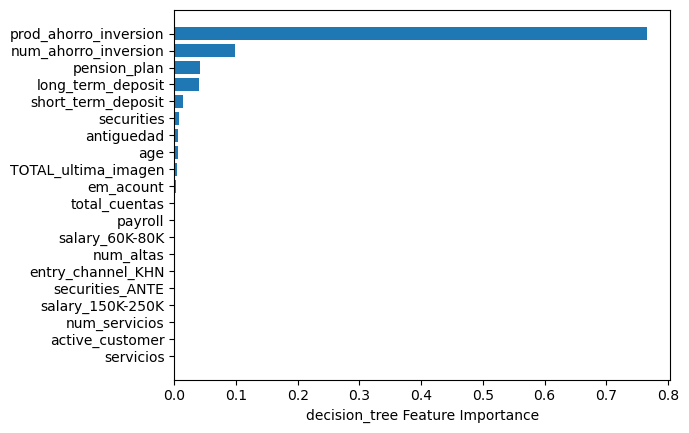

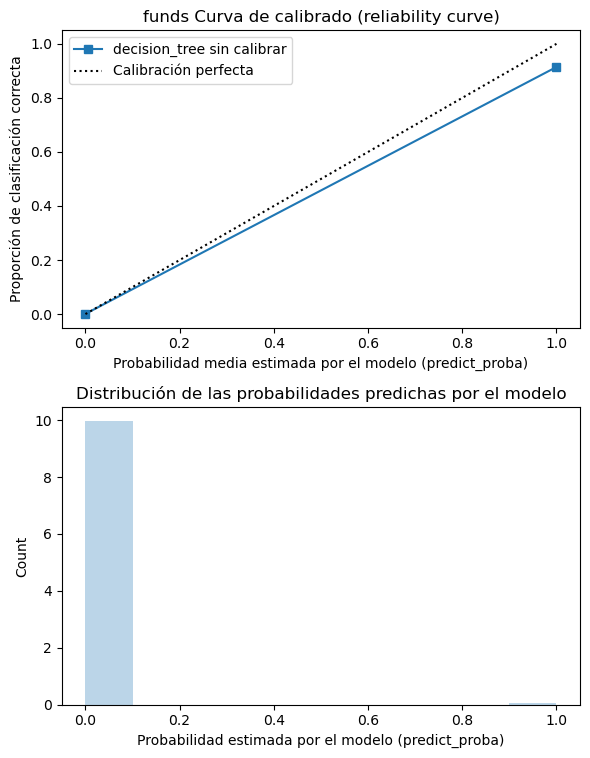

Brier score = 0.0011295393362073835

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52856
           1       0.91      0.85      0.88       263

    accuracy                           1.00     53119
   macro avg       0.96      0.93      0.94     53119
weighted avg       1.00      1.00      1.00     53119

Mean ROC AUC: 0.922


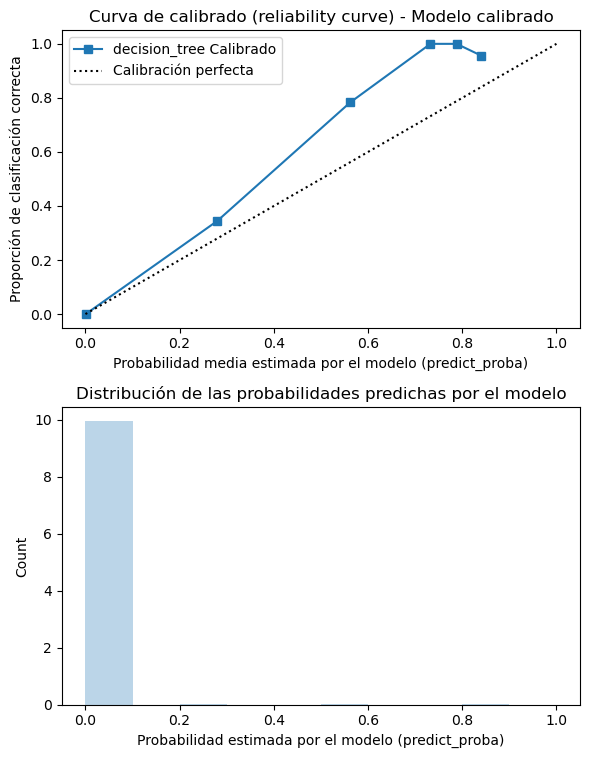

Brier score = 0.001048206055468357

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52856
           1       0.91      0.85      0.88       263

    accuracy                           1.00     53119
   macro avg       0.96      0.93      0.94     53119
weighted avg       1.00      1.00      1.00     53119

Mean ROC AUC: 0.967


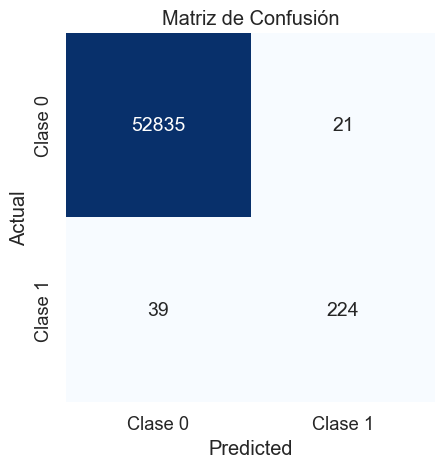

c:\Users\Mikel\anaconda3\envs\Superacion\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     accuracy    recall  precision   f1score
0.2  0.998532  0.927757   0.805281  0.862191
0.4  0.998870  0.851711   0.914286  0.881890
0.5  0.998870  0.851711   0.914286  0.881890
0.6  0.998230  0.673004   0.956757  0.790179
0.7  0.998230  0.673004   0.956757  0.790179
0.8  0.998174  0.661597   0.956044  0.782022
0.9  0.995049  0.000000   0.000000  0.000000


C:\Users\Mikel\AppData\Local\Temp\ipykernel_18556\3095240108.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio['precision umbral 0.5'] = df_metrics_2.loc[0.50, 'precision']
C:\Users\Mikel\AppData\Local\Temp\ipykernel_18556\3095240108.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio[str(target)+'_recalibrado'] = df_limpio['Probabilidad_Clase1'] * df_limpio['precision umbral 0.5']


          key_0  y_funds_recalibrado
0         16063             0.000856
1         16203             0.000856
2         16502             0.000856
3         17457             0.000856
4         17590             0.000856
...         ...                  ...
265587  1548192             0.000856
265588  1548193             0.000856
265589  1548196             0.000856
265590  1548203             0.000856
265591  1548207             0.000856

[264278 rows x 2 columns]
y.shape (265592,)
X.shape (265592, 62)
Revisamos el balanceo
0    263808
1      1784
Name: y_securities, dtype: int64
decision_tree
Fitting 5 folds for each of 20 candidates, totalling 100 fits
random_forest
Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'decision_tree': 0.6999172886322231, 'random_forest': 0.7308725830325252}
Mejor modelo: random_forest
Mejores hiperparametros: {'n_estimators': 80, 'min_samples_split': 2, 'max_depth': 14}


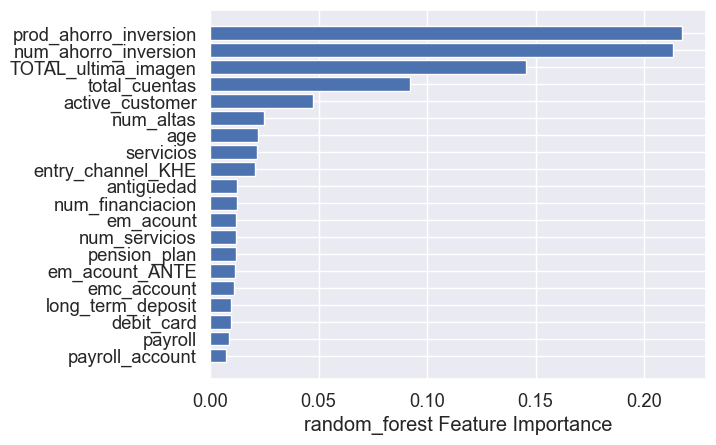

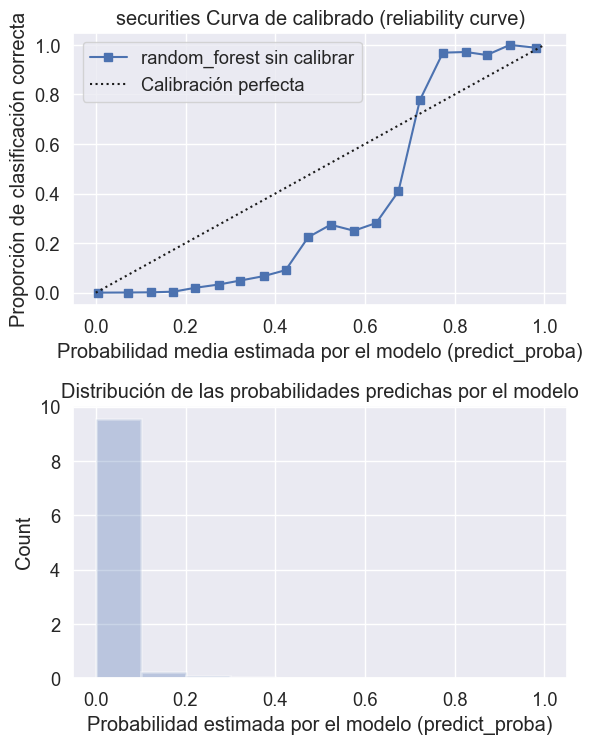

Brier score = 0.0034624548416808862

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52762
           1       0.72      0.87      0.78       357

    accuracy                           1.00     53119
   macro avg       0.86      0.93      0.89     53119
weighted avg       1.00      1.00      1.00     53119

Mean ROC AUC: 0.996


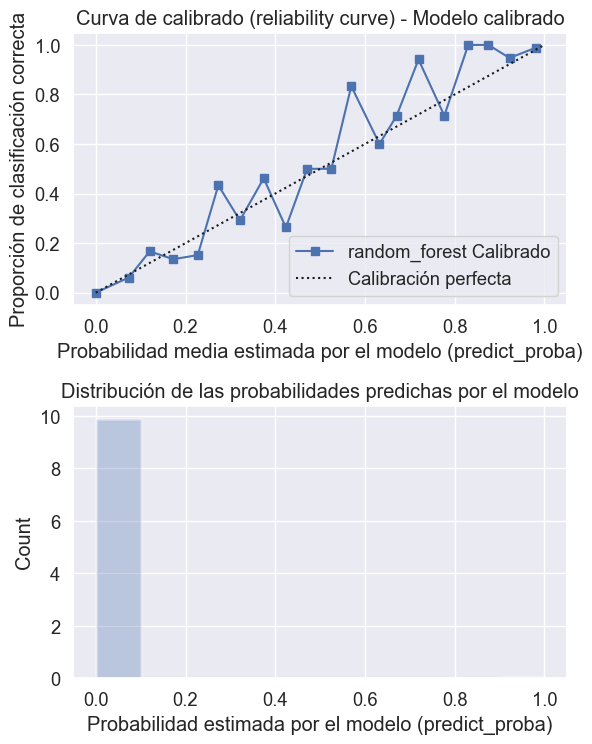

Brier score = 0.0015934377068989487

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52762
           1       0.94      0.75      0.83       357

    accuracy                           1.00     53119
   macro avg       0.97      0.87      0.92     53119
weighted avg       1.00      1.00      1.00     53119

Mean ROC AUC: 0.994


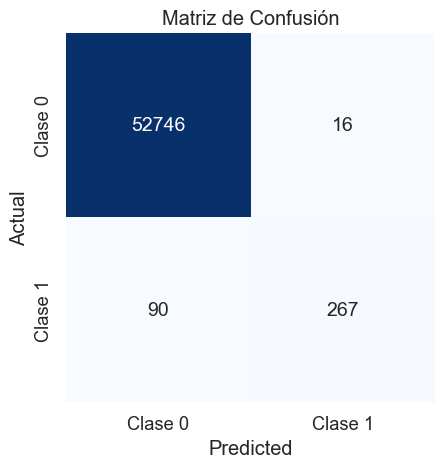

     accuracy    recall  precision   f1score
0.2  0.997120  0.868347   0.745192  0.802070
0.4  0.997835  0.781513   0.882911  0.829123
0.5  0.998004  0.747899   0.943463  0.834375
0.6  0.997929  0.725490   0.955720  0.824841
0.7  0.997835  0.694678   0.976378  0.811784
0.8  0.997496  0.635854   0.986957  0.773424
0.9  0.997082  0.574230   0.985577  0.725664


C:\Users\Mikel\AppData\Local\Temp\ipykernel_18556\3095240108.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio['precision umbral 0.5'] = df_metrics_2.loc[0.50, 'precision']
C:\Users\Mikel\AppData\Local\Temp\ipykernel_18556\3095240108.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio[str(target)+'_recalibrado'] = df_limpio['Probabilidad_Clase1'] * df_limpio['precision umbral 0.5']


          key_0  y_securities_recalibrado
0         16063                  0.000021
1         16203                  0.000021
2         16502                  0.000278
3         17457                  0.070145
4         17590                  0.000068
...         ...                       ...
265587  1548192                  0.000068
265588  1548193                  0.000068
265589  1548196                  0.000068
265590  1548203                  0.001401
265591  1548207                  0.000225

[263808 rows x 2 columns]
y.shape (265592,)
X.shape (265592, 62)
Revisamos el balanceo
0    259476
1      6116
Name: y_long_term_deposit, dtype: int64
decision_tree
Fitting 5 folds for each of 20 candidates, totalling 100 fits
random_forest
Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'decision_tree': 0.9258526843702775, 'random_forest': 0.7770409734334731}
Mejor modelo: decision_tree
Mejores hiperparametros: {'min_samples_split': 2, 'max_depth': 35}


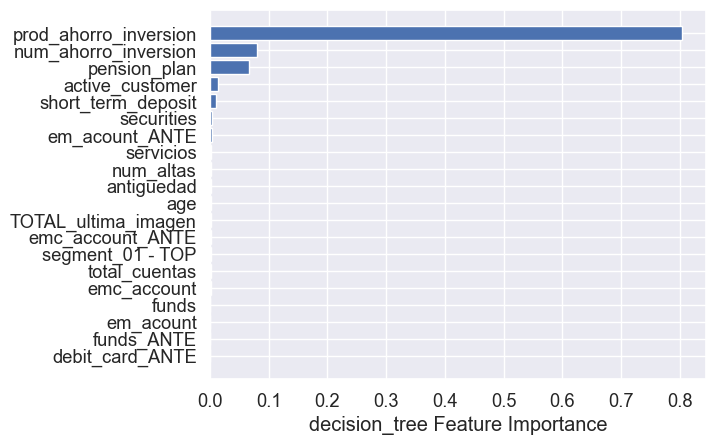

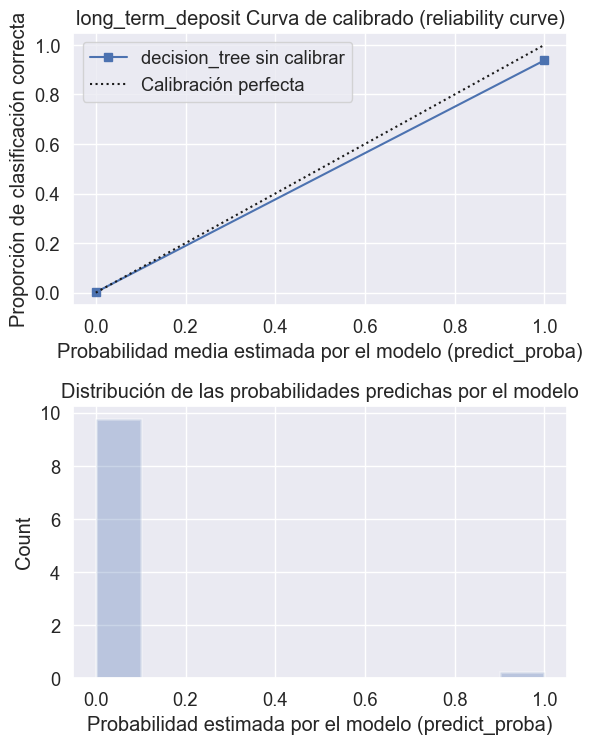

Brier score = 0.0032003614525875864

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51896
           1       0.94      0.92      0.93      1223

    accuracy                           1.00     53119
   macro avg       0.97      0.96      0.96     53119
weighted avg       1.00      1.00      1.00     53119

Mean ROC AUC: 0.956


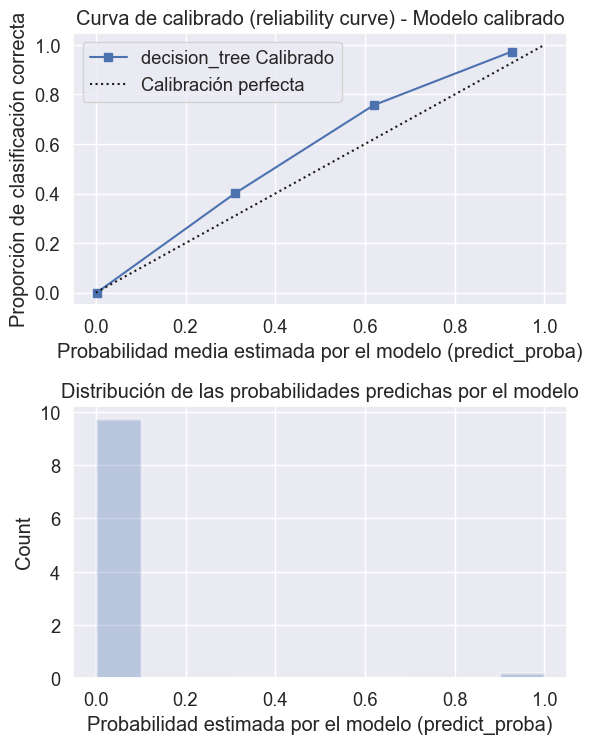

Brier score = 0.0025397011296204247

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51896
           1       0.94      0.92      0.93      1223

    accuracy                           1.00     53119
   macro avg       0.97      0.96      0.97     53119
weighted avg       1.00      1.00      1.00     53119

Mean ROC AUC: 0.987


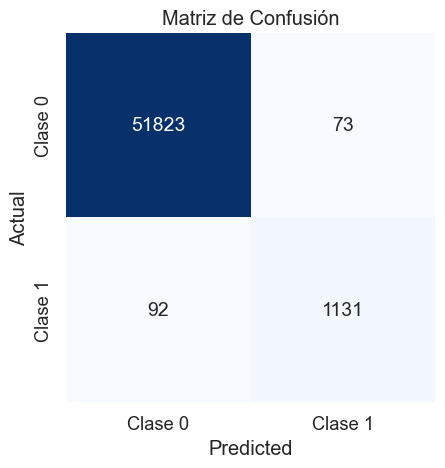

     accuracy    recall  precision   f1score
0.2  0.996310  0.976288   0.877296  0.924149
0.4  0.996894  0.924775   0.939369  0.932015
0.5  0.996894  0.924775   0.939369  0.932015
0.6  0.996894  0.924775   0.939369  0.932015
0.7  0.995068  0.807850   0.973399  0.882931
0.8  0.995068  0.807850   0.973399  0.882931
0.9  0.995068  0.807850   0.973399  0.882931


C:\Users\Mikel\AppData\Local\Temp\ipykernel_18556\3095240108.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio['precision umbral 0.5'] = df_metrics_2.loc[0.50, 'precision']
C:\Users\Mikel\AppData\Local\Temp\ipykernel_18556\3095240108.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio[str(target)+'_recalibrado'] = df_limpio['Probabilidad_Clase1'] * df_limpio['precision umbral 0.5']


          key_0  y_long_term_deposit_recalibrado
0         16063                         0.002184
1         16203                         0.002184
2         16502                         0.002184
4         17590                         0.002184
5         17799                         0.002184
...         ...                              ...
265587  1548192                         0.002184
265588  1548193                         0.002184
265589  1548196                         0.002184
265590  1548203                         0.002184
265591  1548207                         0.002184

[259476 rows x 2 columns]
y.shape (265592,)
X.shape (265592, 62)
Revisamos el balanceo
0    260801
1      4791
Name: y_credit_card, dtype: int64
decision_tree
Fitting 5 folds for each of 20 candidates, totalling 100 fits
random_forest
Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'decision_tree': 0.31099291704872656, 'random_forest': 0.5896672121593798}
Mejor modelo: random_forest
Mejores hi

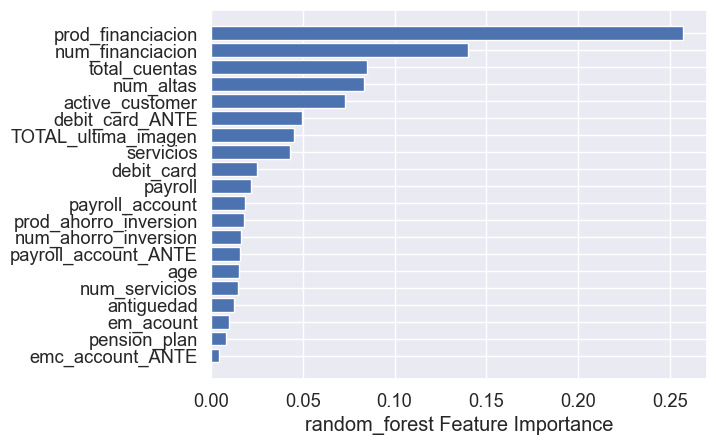

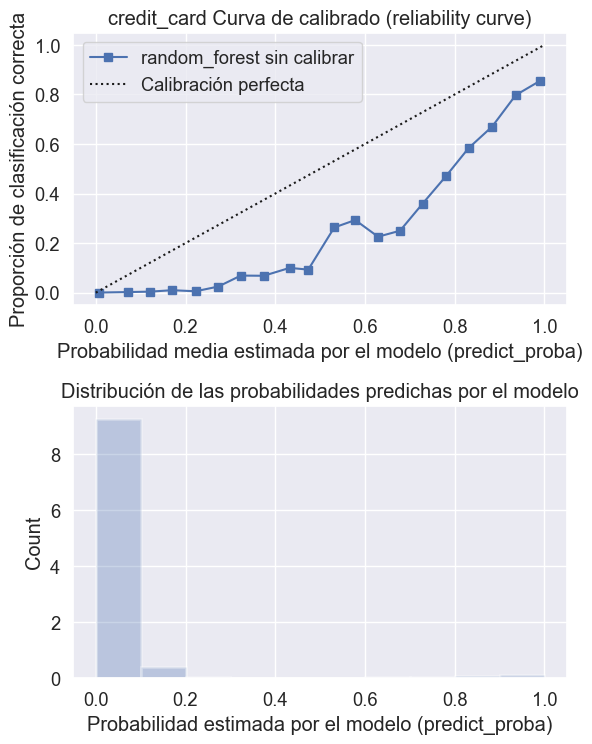

Brier score = 0.010015573291077147

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     52161
           1       0.60      0.93      0.73       958

    accuracy                           0.99     53119
   macro avg       0.80      0.96      0.86     53119
weighted avg       0.99      0.99      0.99     53119

Mean ROC AUC: 0.988


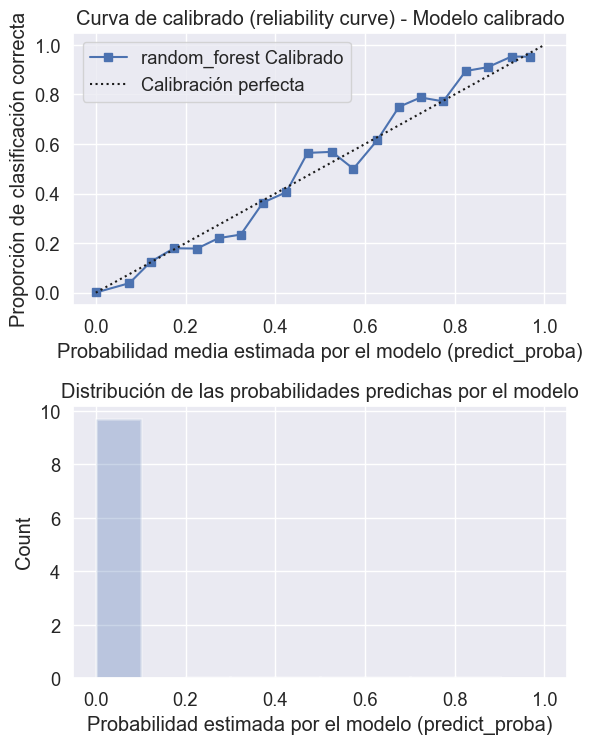

Brier score = 0.006110513512351555

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52161
           1       0.76      0.76      0.76       958

    accuracy                           0.99     53119
   macro avg       0.88      0.88      0.88     53119
weighted avg       0.99      0.99      0.99     53119

Mean ROC AUC: 0.986


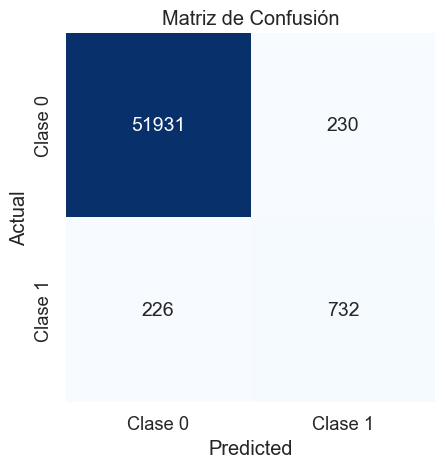

     accuracy    recall  precision   f1score
0.2  0.988196  0.926931   0.614533  0.739076
0.4  0.991340  0.841336   0.723519  0.777992
0.5  0.991416  0.764092   0.760915  0.762500
0.6  0.991171  0.661795   0.813864  0.729994
0.7  0.989815  0.529228   0.849246  0.652090
0.8  0.986766  0.293319   0.915309  0.444269
0.9  0.983415  0.084551   0.952941  0.155321


C:\Users\Mikel\AppData\Local\Temp\ipykernel_18556\3095240108.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio['precision umbral 0.5'] = df_metrics_2.loc[0.50, 'precision']
C:\Users\Mikel\AppData\Local\Temp\ipykernel_18556\3095240108.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio[str(target)+'_recalibrado'] = df_limpio['Probabilidad_Clase1'] * df_limpio['precision umbral 0.5']


          key_0  y_credit_card_recalibrado
0         16063                   0.000483
1         16203                   0.002421
2         16502                   0.001994
3         17457                   0.002247
4         17590                   0.000956
...         ...                        ...
265587  1548192                   0.000483
265588  1548193                   0.000741
265589  1548196                   0.002010
265590  1548203                   0.001261
265591  1548207                   0.000423

[260801 rows x 2 columns]
y.shape (265592,)
X.shape (265592, 62)
Revisamos el balanceo
0.0    249417
1.0     16175
Name: y_payroll, dtype: int64
decision_tree
Fitting 5 folds for each of 20 candidates, totalling 100 fits
random_forest
Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'decision_tree': 0.6576457382744165, 'random_forest': 0.7452204347892092}
Mejor modelo: random_forest
Mejores hiperparametros: {'n_estimators': 20, 'min_samples_split': 6, 'max_depth': 

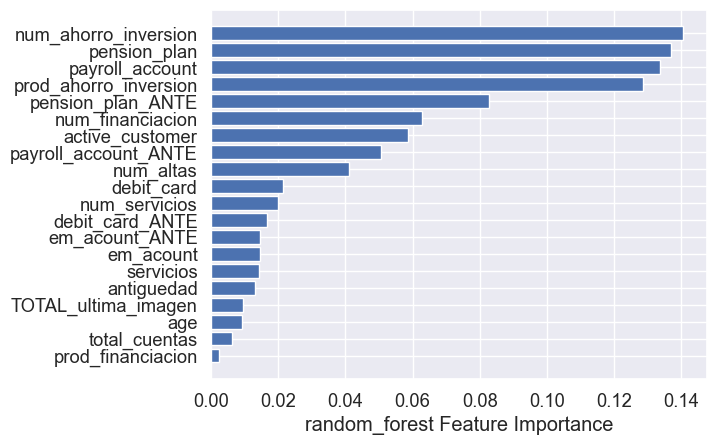

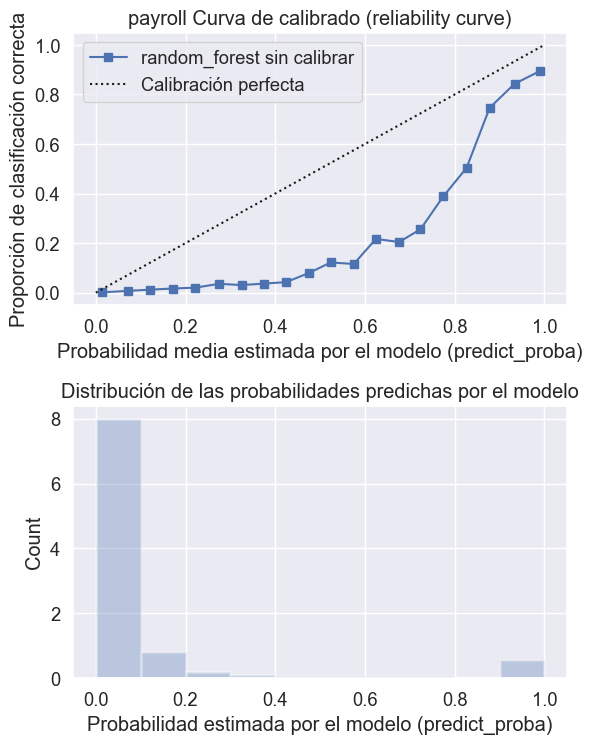

Brier score = 0.023795178101041245

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98     49884
         1.0       0.70      0.93      0.80      3235

    accuracy                           0.97     53119
   macro avg       0.85      0.95      0.89     53119
weighted avg       0.98      0.97      0.97     53119

Mean ROC AUC: 0.983


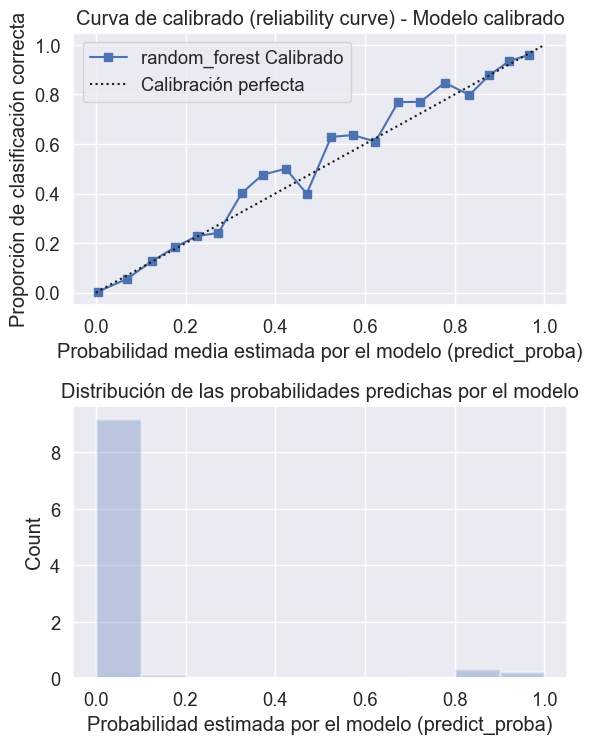

Brier score = 0.013930706850037158

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     49884
         1.0       0.88      0.85      0.86      3235

    accuracy                           0.98     53119
   macro avg       0.93      0.92      0.93     53119
weighted avg       0.98      0.98      0.98     53119

Mean ROC AUC: 0.983


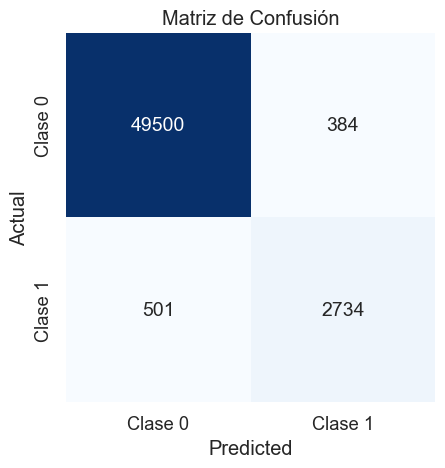

     accuracy    recall  precision   f1score
0.2  0.979518  0.902318   0.790843  0.842911
0.4  0.983208  0.856878   0.865979  0.861405
0.5  0.983339  0.845131   0.876844  0.860696
0.6  0.983000  0.831839   0.882295  0.856325
0.7  0.982436  0.814838   0.887542  0.849637
0.8  0.980308  0.769706   0.892153  0.826419
0.9  0.957303  0.317465   0.944802  0.475243


C:\Users\Mikel\AppData\Local\Temp\ipykernel_18556\3095240108.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio['precision umbral 0.5'] = df_metrics_2.loc[0.50, 'precision']
C:\Users\Mikel\AppData\Local\Temp\ipykernel_18556\3095240108.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio[str(target)+'_recalibrado'] = df_limpio['Probabilidad_Clase1'] * df_limpio['precision umbral 0.5']


          key_0  y_payroll_recalibrado
0         16063               0.000268
1         16203               0.004915
2         16502               0.006035
3         17457               0.003796
4         17590               0.000758
...         ...                    ...
265587  1548192               0.002826
265588  1548193               0.004676
265589  1548196               0.031735
265590  1548203               0.059068
265591  1548207               0.004588

[249417 rows x 2 columns]
y.shape (265592,)
X.shape (265592, 62)
Revisamos el balanceo
0.0    248400
1.0     17192
Name: y_pension_plan, dtype: int64
decision_tree
Fitting 5 folds for each of 20 candidates, totalling 100 fits
random_forest
Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'decision_tree': 0.6573644847341588, 'random_forest': 0.7632819766167709}
Mejor modelo: random_forest
Mejores hiperparametros: {'n_estimators': 20, 'min_samples_split': 4, 'max_depth': 14}


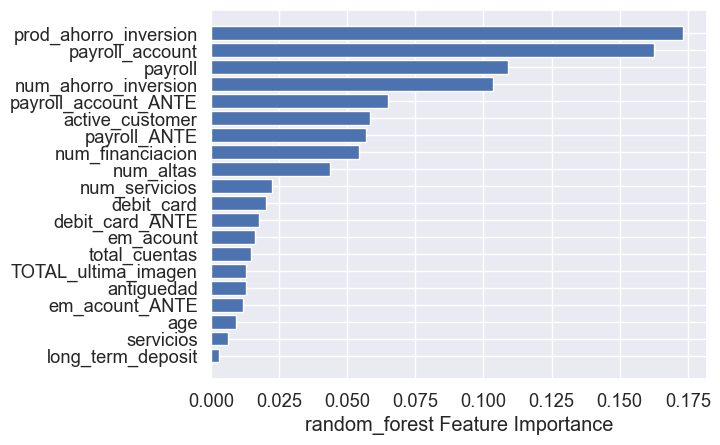

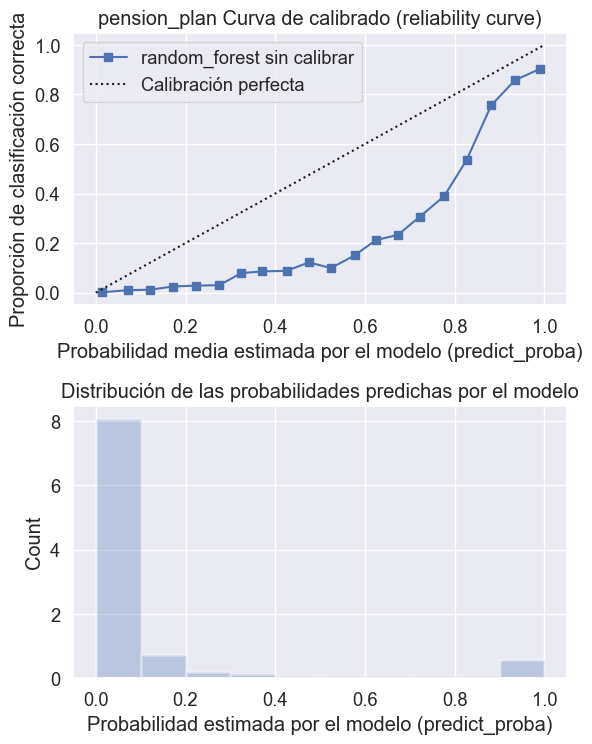

Brier score = 0.024125761325297503

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     49681
         1.0       0.71      0.91      0.80      3438

    accuracy                           0.97     53119
   macro avg       0.85      0.94      0.89     53119
weighted avg       0.98      0.97      0.97     53119

Mean ROC AUC: 0.983


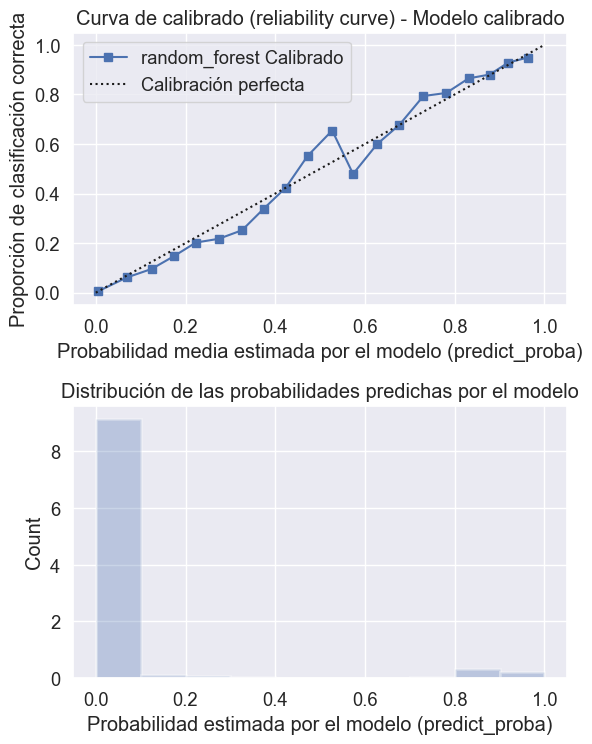

Brier score = 0.015083611803217602

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     49681
         1.0       0.87      0.84      0.86      3438

    accuracy                           0.98     53119
   macro avg       0.93      0.92      0.92     53119
weighted avg       0.98      0.98      0.98     53119

Mean ROC AUC: 0.983


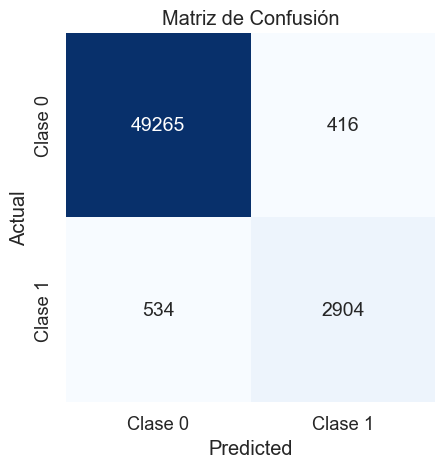

     accuracy    recall  precision   f1score
0.2  0.976788  0.899069   0.777219  0.833715
0.4  0.982078  0.862711   0.860708  0.861708
0.5  0.982116  0.844677   0.874699  0.859426
0.6  0.981833  0.827516   0.884364  0.854996
0.7  0.981156  0.803374   0.894720  0.846590
0.8  0.978972  0.758581   0.900864  0.823622
0.9  0.954517  0.319372   0.935264  0.476149


C:\Users\Mikel\AppData\Local\Temp\ipykernel_18556\3095240108.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio['precision umbral 0.5'] = df_metrics_2.loc[0.50, 'precision']
C:\Users\Mikel\AppData\Local\Temp\ipykernel_18556\3095240108.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio[str(target)+'_recalibrado'] = df_limpio['Probabilidad_Clase1'] * df_limpio['precision umbral 0.5']


          key_0  y_pension_plan_recalibrado
0         16063                    0.000380
1         16203                    0.006788
2         16502                    0.007220
3         17457                    0.002677
4         17590                    0.000534
...         ...                         ...
265587  1548192                    0.010263
265588  1548193                    0.004031
265589  1548196                    0.024638
265590  1548203                    0.083033
265591  1548207                    0.007498

[248400 rows x 2 columns]
y.shape (265592,)
X.shape (265592, 62)
Revisamos el balanceo
0    239184
1     26408
Name: y_payroll_account, dtype: int64
decision_tree
Fitting 5 folds for each of 20 candidates, totalling 100 fits
random_forest
Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'decision_tree': 0.8831793422313297, 'random_forest': 0.9585881518891668}
Mejor modelo: random_forest
Mejores hiperparametros: {'n_estimators': 80, 'min_samples_split': 

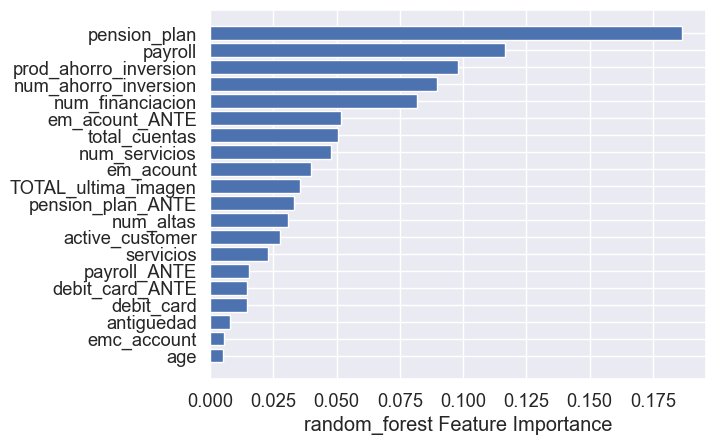

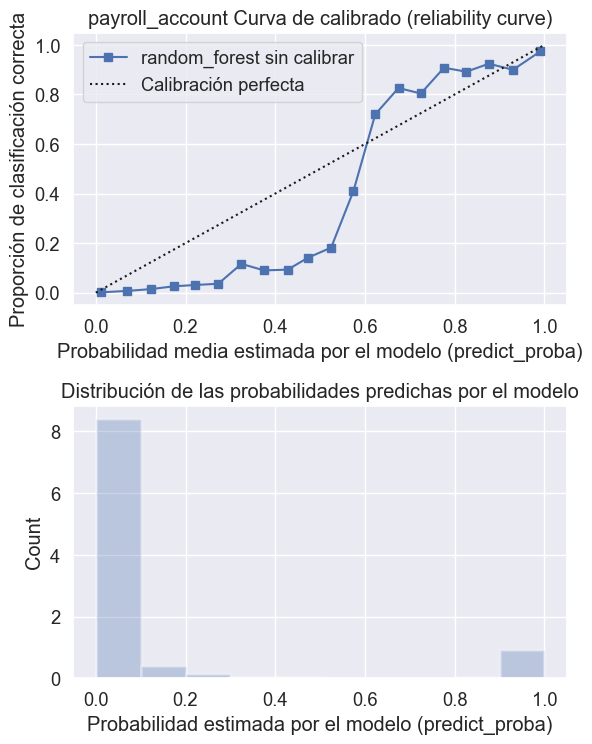

Brier score = 0.009814875975718076

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     47837
           1       0.95      0.96      0.96      5282

    accuracy                           0.99     53119
   macro avg       0.97      0.98      0.98     53119
weighted avg       0.99      0.99      0.99     53119

Mean ROC AUC: 0.994


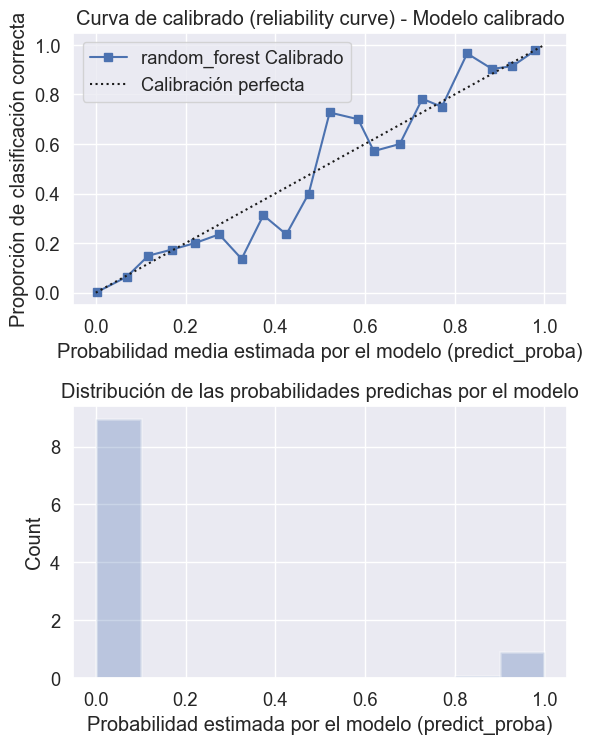

Brier score = 0.007370491951972526

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     47837
           1       0.96      0.96      0.96      5282

    accuracy                           0.99     53119
   macro avg       0.98      0.98      0.98     53119
weighted avg       0.99      0.99      0.99     53119

Mean ROC AUC: 0.994


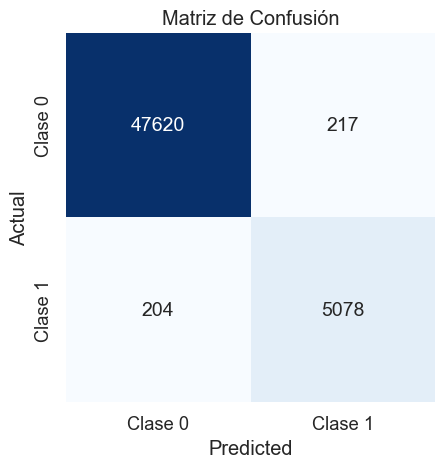

     accuracy    recall  precision   f1score
0.2  0.991001  0.966111   0.944650  0.955260
0.4  0.991867  0.962893   0.955656  0.959261
0.5  0.992074  0.961378   0.959018  0.960197
0.6  0.991905  0.958538   0.959992  0.959265
0.7  0.991830  0.955888   0.961714  0.958792
0.8  0.991284  0.947936   0.963811  0.955808
0.9  0.985278  0.880727   0.968360  0.922467


C:\Users\Mikel\AppData\Local\Temp\ipykernel_18556\3095240108.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio['precision umbral 0.5'] = df_metrics_2.loc[0.50, 'precision']
C:\Users\Mikel\AppData\Local\Temp\ipykernel_18556\3095240108.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio[str(target)+'_recalibrado'] = df_limpio['Probabilidad_Clase1'] * df_limpio['precision umbral 0.5']


          key_0  y_payroll_account_recalibrado
0         16063                       0.000512
1         16203                       0.005889
2         16502                       0.006775
3         17457                       0.001935
4         17590                       0.000936
...         ...                            ...
265587  1548192                       0.001676
265588  1548193                       0.000778
265589  1548196                       0.022541
265590  1548203                       0.046891
265591  1548207                       0.002564

[239184 rows x 2 columns]
y.shape (265592,)
X.shape (265592, 62)
Revisamos el balanceo
0    240944
1     24648
Name: y_emc_account, dtype: int64
decision_tree
Fitting 5 folds for each of 20 candidates, totalling 100 fits
random_forest
Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'decision_tree': 0.7170577437761088, 'random_forest': 0.8421950499678571}
Mejor modelo: random_forest
Mejores hiperparametros: {'n_estima

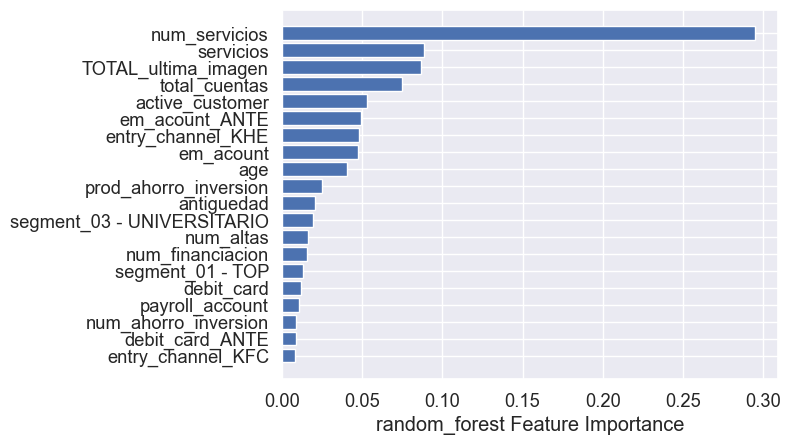

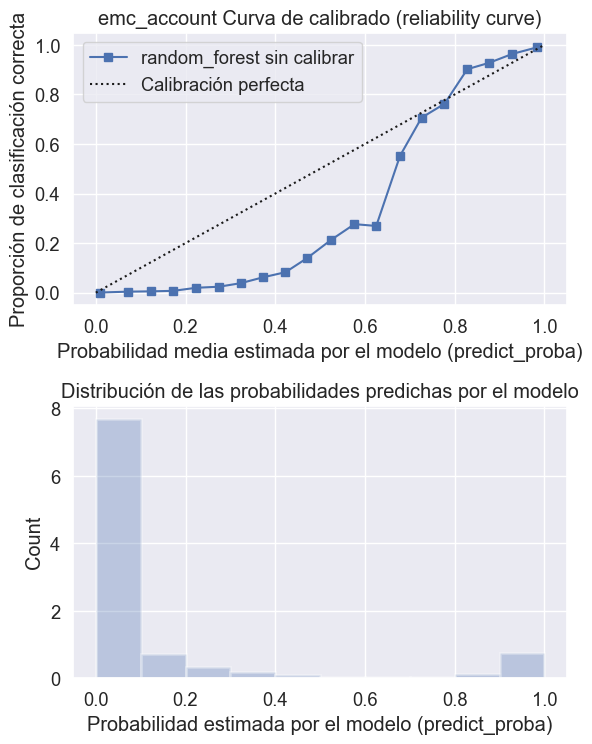

Brier score = 0.01475679837116581

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     48189
           1       0.92      0.96      0.94      4930

    accuracy                           0.99     53119
   macro avg       0.96      0.98      0.97     53119
weighted avg       0.99      0.99      0.99     53119

Mean ROC AUC: 0.995


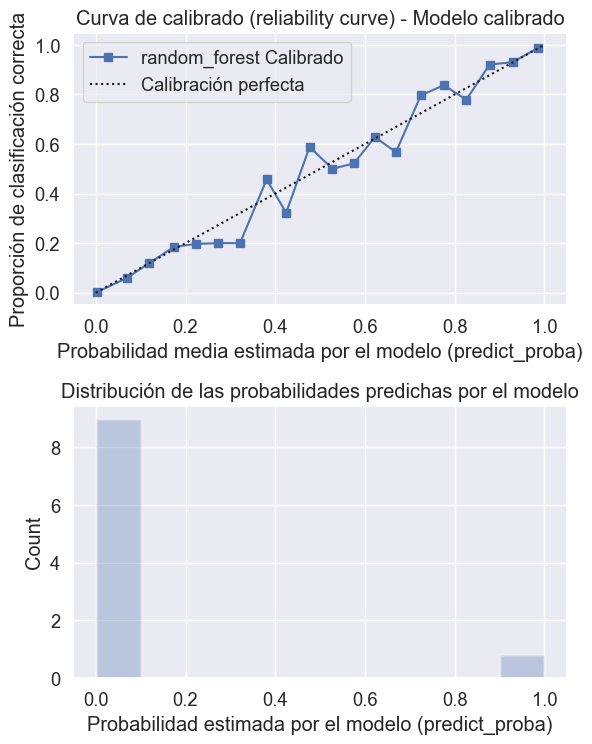

Brier score = 0.007873832529099048

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     48189
           1       0.96      0.94      0.95      4930

    accuracy                           0.99     53119
   macro avg       0.97      0.97      0.97     53119
weighted avg       0.99      0.99      0.99     53119

Mean ROC AUC: 0.995


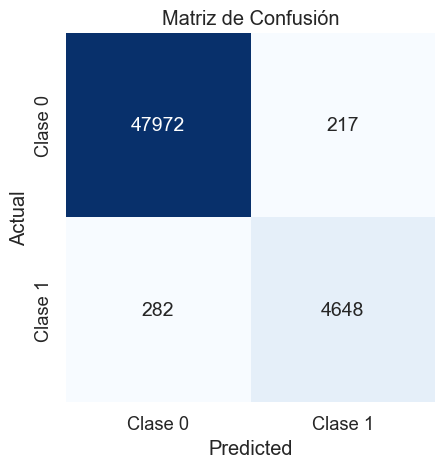

     accuracy    recall  precision   f1score
0.2  0.988686  0.958418   0.922671  0.940205
0.4  0.990512  0.948884   0.948884  0.948884
0.5  0.990606  0.942799   0.955396  0.949056
0.6  0.990568  0.934483   0.962800  0.948430
0.7  0.990267  0.924746   0.968969  0.946341
0.8  0.988648  0.902434   0.973310  0.936533
0.9  0.984375  0.847870   0.981221  0.909684


C:\Users\Mikel\AppData\Local\Temp\ipykernel_18556\3095240108.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio['precision umbral 0.5'] = df_metrics_2.loc[0.50, 'precision']
C:\Users\Mikel\AppData\Local\Temp\ipykernel_18556\3095240108.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio[str(target)+'_recalibrado'] = df_limpio['Probabilidad_Clase1'] * df_limpio['precision umbral 0.5']


          key_0  y_emc_account_recalibrado
0         16063                   0.000600
1         16203                   0.625304
3         17457                   0.022446
4         17590                   0.003644
5         17799                   0.003757
...         ...                        ...
265587  1548192                   0.002294
265588  1548193                   0.000959
265589  1548196                   0.006975
265590  1548203                   0.005229
265591  1548207                   0.000733

[240944 rows x 2 columns]
y.shape (265592,)
X.shape (265592, 62)
Revisamos el balanceo
0    222779
1     42813
Name: y_debit_card, dtype: int64
decision_tree
Fitting 5 folds for each of 20 candidates, totalling 100 fits
random_forest
Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'decision_tree': 0.7584013863917483, 'random_forest': 0.8145907188962861}
Mejor modelo: random_forest
Mejores hiperparametros: {'n_estimators': 20, 'min_samples_split': 4, 'max_depth': 1

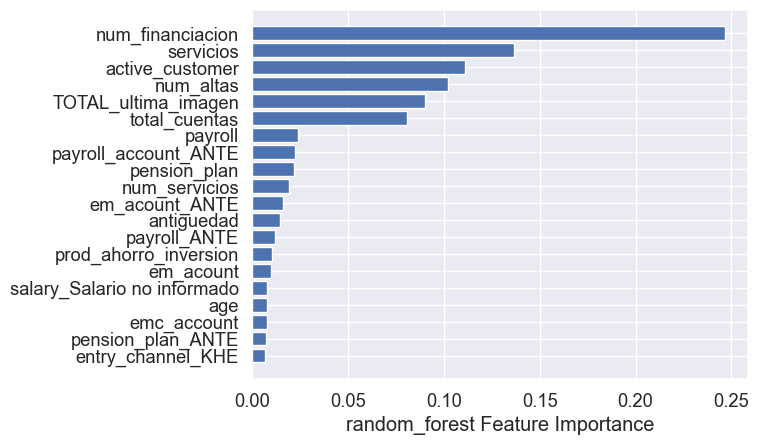

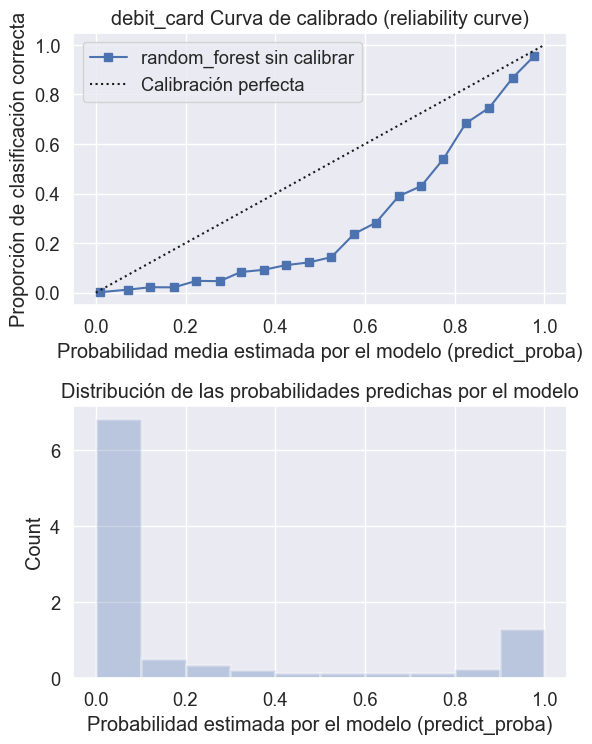

Brier score = 0.03904963243499742

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     44556
           1       0.79      0.95      0.86      8563

    accuracy                           0.95     53119
   macro avg       0.89      0.95      0.91     53119
weighted avg       0.96      0.95      0.95     53119

Mean ROC AUC: 0.986


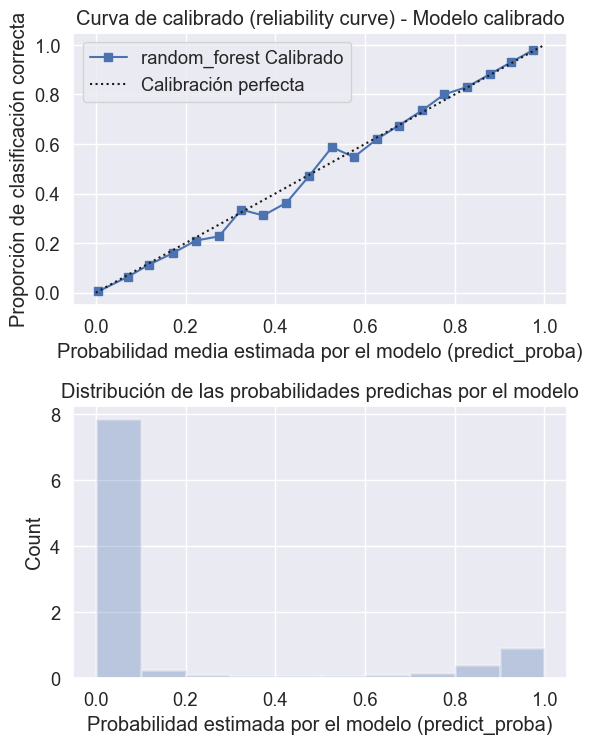

Brier score = 0.028619847798740963

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     44556
           1       0.88      0.90      0.89      8563

    accuracy                           0.96     53119
   macro avg       0.93      0.94      0.93     53119
weighted avg       0.96      0.96      0.96     53119

Mean ROC AUC: 0.986


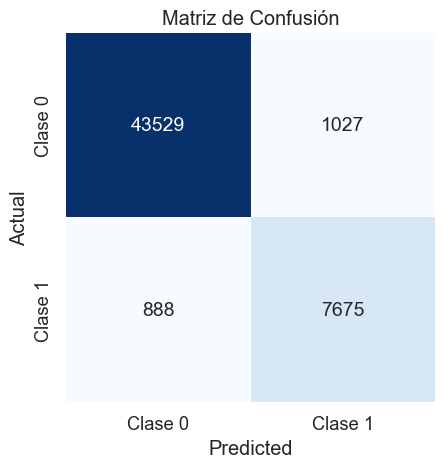

     accuracy    recall  precision   f1score
0.2  0.954555  0.941142   0.808406  0.869739
0.4  0.962838  0.912764   0.864315  0.887879
0.5  0.963949  0.896298   0.881981  0.889082
0.6  0.962895  0.867687   0.898645  0.882895
0.7  0.959995  0.828565   0.915248  0.869752
0.8  0.951976  0.758496   0.930782  0.835854
0.9  0.923267  0.547472   0.958887  0.696997


C:\Users\Mikel\AppData\Local\Temp\ipykernel_18556\3095240108.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio['precision umbral 0.5'] = df_metrics_2.loc[0.50, 'precision']
C:\Users\Mikel\AppData\Local\Temp\ipykernel_18556\3095240108.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio[str(target)+'_recalibrado'] = df_limpio['Probabilidad_Clase1'] * df_limpio['precision umbral 0.5']


          key_0  y_debit_card_recalibrado
0         16063                  0.000915
1         16203                  0.019386
2         16502                  0.016792
4         17590                  0.001634
5         17799                  0.014054
...         ...                       ...
265586  1548191                  0.004179
265587  1548192                  0.002597
265588  1548193                  0.004179
265590  1548203                  0.076341
265591  1548207                  0.003412

[222779 rows x 2 columns]
y.shape (265592,)
X.shape (265592, 62)
Revisamos el balanceo
1    159263
0    106329
Name: y_em_acount, dtype: int64
decision_tree
Fitting 5 folds for each of 20 candidates, totalling 100 fits
random_forest
Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'decision_tree': 0.9419552234973315, 'random_forest': 0.9776012400331631}
Mejor modelo: random_forest
Mejores hiperparametros: {'n_estimators': 80, 'min_samples_split': 6, 'max_depth': 14}


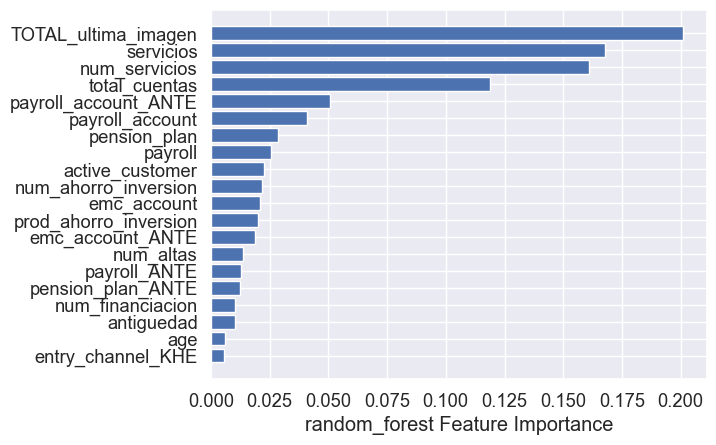

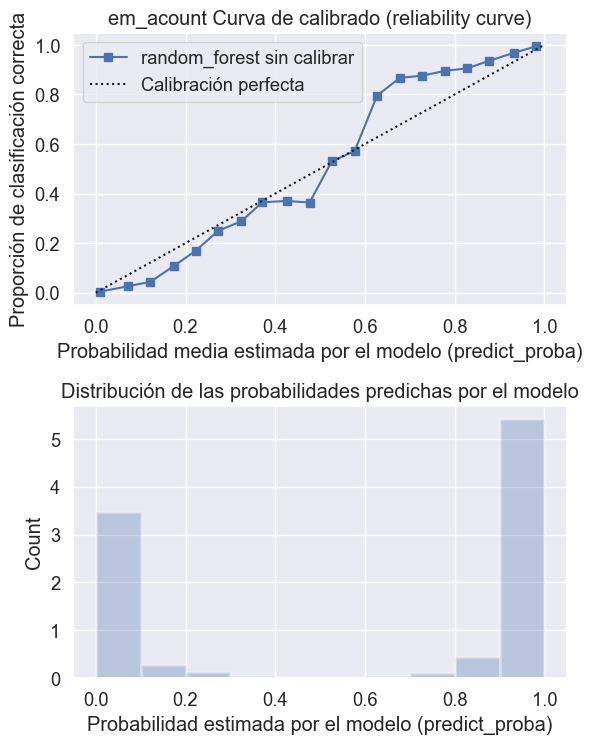

Brier score = 0.020516877686786585

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     21266
           1       0.98      0.99      0.98     31853

    accuracy                           0.98     53119
   macro avg       0.98      0.98      0.98     53119
weighted avg       0.98      0.98      0.98     53119

Mean ROC AUC: 0.993


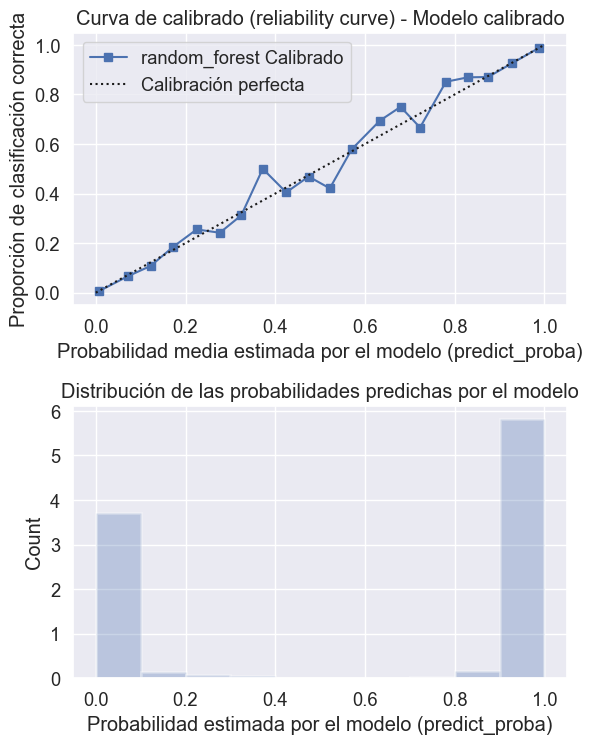

Brier score = 0.019418069477696826

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     21266
           1       0.98      0.99      0.98     31853

    accuracy                           0.98     53119
   macro avg       0.98      0.98      0.98     53119
weighted avg       0.98      0.98      0.98     53119

Mean ROC AUC: 0.992


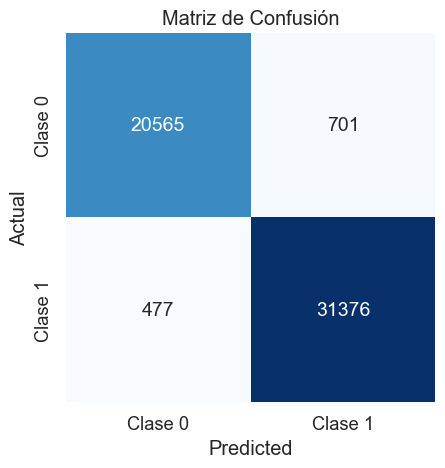

     accuracy    recall  precision   f1score
0.2  0.973155  0.991524   0.964690  0.977923
0.4  0.977635  0.986030   0.976890  0.981439
0.5  0.977823  0.985025   0.978146  0.981574
0.6  0.977823  0.984428   0.978713  0.981563
0.7  0.977221  0.982796   0.979291  0.981040
0.8  0.975960  0.979876   0.980030  0.979953
0.9  0.963158  0.954792   0.983285  0.968829
          key_0  y_em_acount_recalibrado
0         16063                 0.007182
4         17590                 0.001507
6         17970                 0.026389
7         17980                 0.151144
8         18146                 0.055808
...         ...                      ...
265578  1548177                 0.017284
265586  1548191                 0.038035
265587  1548192                 0.021986
265588  1548193                 0.034319
265591  1548207                 0.018791

[106329 rows x 2 columns]


C:\Users\Mikel\AppData\Local\Temp\ipykernel_18556\3095240108.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio['precision umbral 0.5'] = df_metrics_2.loc[0.50, 'precision']
C:\Users\Mikel\AppData\Local\Temp\ipykernel_18556\3095240108.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio[str(target)+'_recalibrado'] = df_limpio['Probabilidad_Clase1'] * df_limpio['precision umbral 0.5']


In [10]:
productos = [x[2:] for x in df_entrenar_all.columns[-10:]]
dic_modelos={}
dic_pred={}
for producto_modelo in productos:
    X,y, target, filtro = preparar_datos(producto_modelo)
    mejor_modelo, parametros_optimizados = modelos_Random_Search(X,y)
    modelo_calibrado_1, df_metrics_2, roc_auc_2 = entrenar_mejor_modelo(mejor_modelo, parametros_optimizados)
    df_limpio = Predicciones(df_predicciones)
    dic_pred, dic_modelos = crear_diccionarios(df_limpio,mejor_modelo, parametros_optimizados,df_metrics_2,roc_auc_2 )

In [11]:
# Crear un DataFrame inicial con una columna 'key_0'
finalista = pd.DataFrame(columns=['key_0'])

# Iterar sobre las claves y valores del diccionario
for b, df_pred in dic_pred.items():
    # Realizar un merge (combinación) con el DataFrame actual
    finalista = pd.merge(finalista, df_pred, how='outer', on='key_0')

In [12]:
finalista

,key_0,y_funds_recalibrado,y_securities_recalibrado,y_long_term_deposit_recalibrado,y_credit_card_recalibrado,y_payroll_recalibrado,y_pension_plan_recalibrado,y_payroll_account_recalibrado,y_emc_account_recalibrado,y_debit_card_recalibrado,y_em_acount_recalibrado
0,16063,0.000856,0.000021,0.002184,0.000483,0.000268,0.000380,0.000512,0.000600,0.000915,0.007182
1,16203,0.000856,0.000021,0.002184,0.002421,0.004915,0.006788,0.005889,0.625304,0.019386,NaN
2,16502,0.000856,0.000278,0.002184,0.001994,0.006035,0.007220,0.006775,NaN,0.016792,NaN
3,17457,0.000856,0.070145,NaN,0.002247,0.003796,0.002677,0.001935,0.022446,NaN,NaN
4,17590,0.000856,0.000068,0.002184,0.000956,0.000758,0.000534,0.000936,0.003644,0.001634,0.001507
...,...,...,...,...,...,...,...,...,...,...,...
265587,1148145,NaN,NaN,NaN,NaN,0.000243,0.005078,0.014572,NaN,0.139947,NaN
265588,1238812,NaN,NaN,NaN,NaN,0.002542,0.006735,0.043496,NaN,NaN,NaN
265589,1250058,NaN,NaN,NaN,NaN,0.147979,NaN,0.084173,0.014484,NaN,NaN
265590,1124128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.229871


In [13]:
finalista = finalista.set_index('key_0')

In [14]:
# hacemos la ponderacion de la puntuación teniendo en cuenta el ingreso por producto
cuentas = 10
col_cuentas = ['y_payroll_recalibrado','y_payroll_account_recalibrado', 'y_emc_account_recalibrado', 'y_debit_card_recalibrado', 'y_em_acount_recalibrado']
for x in col_cuentas:
    finalista[f'{x[2:][:-12]}'] = finalista[x]*cuentas

ahorro = 40
col_ahorro = ['y_funds_recalibrado', 'y_securities_recalibrado','y_long_term_deposit_recalibrado','y_pension_plan_recalibrado']
for x in col_ahorro:
    finalista[f'{x[2:][:-12]}'] = finalista[x]*ahorro

financiacion = 60
col_financiacion = ['y_credit_card_recalibrado']
for x in col_financiacion:
    finalista[f'{x[2:][:-12]}'] = finalista[x]*financiacion

In [17]:
# non quedamos con el producto por usuario con mayor puntuación
columna_max = finalista[finalista.columns[10:]].idxmax(axis=1)
finalista['Columna_Max'] = columna_max

# sacamos la puntuiacion
finalista['puntuacion'] = finalista[finalista.columns[10:-1]].max(axis=1)

# eliminamos aqueloos usuarios para los que el modelo no haya hecho predicciones
finalista = finalista[~finalista['Columna_Max'].isna()]

In [21]:
# Sacamos la probabilidad para esos productos seleccionados

# Función para obtener el valor del producto seleccionado
def obtener_valor_producto_seleccionado(row):
    seleccion = row['Columna_Max']  # Obtener el valor de la columna 'seleccion'
    producto = row[f'y_{seleccion}_recalibrado']  # Obtener el valor del producto seleccionado
    return producto

# Aplicamos la función en cada fila del DataFrame
finalista['bola_magica'] = finalista.apply(obtener_valor_producto_seleccionado, axis=1)

finalista

,y_funds_recalibrado,y_securities_recalibrado,y_long_term_deposit_recalibrado,y_credit_card_recalibrado,y_payroll_recalibrado,y_pension_plan_recalibrado,y_payroll_account_recalibrado,y_emc_account_recalibrado,y_debit_card_recalibrado,y_em_acount_recalibrado,...,debit_card,em_acount,funds,securities,long_term_deposit,pension_plan,credit_card,Columna_Max,puntuacion,bola_magica
key_0,,,,,,,,,,,,,,,,,,,,,
16063,0.000856,0.000021,0.002184,0.000483,0.000268,0.000380,0.000512,0.000600,0.000915,0.007182,...,0.009151,0.071820,0.034244,0.000859,0.087371,0.015205,0.028967,long_term_deposit,0.087371,0.002184
16203,0.000856,0.000021,0.002184,0.002421,0.004915,0.006788,0.005889,0.625304,0.019386,NaN,...,0.193859,NaN,0.034244,0.000859,0.087371,0.271502,0.145281,emc_account,6.253036,0.625304
16502,0.000856,0.000278,0.002184,0.001994,0.006035,0.007220,0.006775,NaN,0.016792,NaN,...,0.167924,NaN,0.034244,0.011113,0.087371,0.288793,0.119618,pension_plan,0.288793,0.007220
17457,0.000856,0.070145,NaN,0.002247,0.003796,0.002677,0.001935,0.022446,NaN,NaN,...,NaN,NaN,0.034244,2.805817,NaN,0.107070,0.134822,securities,2.805817,0.070145
17590,0.000856,0.000068,0.002184,0.000956,0.000758,0.000534,0.000936,0.003644,0.001634,0.001507,...,0.016337,0.015072,0.034244,0.002728,0.087371,0.021370,0.057348,long_term_deposit,0.087371,0.002184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148145,NaN,NaN,NaN,NaN,0.000243,0.005078,0.014572,NaN,0.139947,NaN,...,1.399469,NaN,NaN,NaN,NaN,0.203119,NaN,debit_card,1.399469,0.139947
1238812,NaN,NaN,NaN,NaN,0.002542,0.006735,0.043496,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.269384,NaN,payroll_account,0.434959,0.043496
1250058,NaN,NaN,NaN,NaN,0.147979,NaN,0.084173,0.014484,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,payroll,1.479791,0.147979


In [22]:
finalista.T

key_0,16063,16203,16502,17457,17590,17799,17970,18146,18704,18956,...,1379658,1389468,1408595,1076441,1083752,1148145,1238812,1250058,1124128,1128353
y_funds_recalibrado,0.000856,0.000856,0.000856,0.000856,0.000856,0.000856,0.000856,0.000856,0.000856,0.000856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
y_securities_recalibrado,0.000021,0.000021,0.000278,0.070145,0.000068,0.000021,NaN,0.000121,0.000021,0.000021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
y_long_term_deposit_recalibrado,0.002184,0.002184,0.002184,NaN,0.002184,0.002184,0.002184,0.002184,0.002184,0.002184,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
y_credit_card_recalibrado,0.000483,0.002421,0.001994,0.002247,0.000956,0.002232,0.007373,0.001163,0.000831,0.001163,...,0.000148,0.033304,0.002653,NaN,NaN,NaN,NaN,NaN,NaN,NaN
y_payroll_recalibrado,0.000268,0.004915,0.006035,0.003796,0.000758,0.004238,0.176783,0.002608,0.003406,0.00038,...,0.000704,0.002526,NaN,0.006737,0.01529,0.000243,0.002542,0.147979,NaN,NaN
y_pension_plan_recalibrado,0.00038,0.006788,0.00722,0.002677,0.000534,0.003148,NaN,0.002948,0.003024,0.001639,...,0.005713,0.025742,NaN,0.00409,0.065901,0.005078,0.006735,NaN,NaN,NaN
y_payroll_account_recalibrado,0.000512,0.005889,0.006775,0.001935,0.000936,0.002783,NaN,0.006424,0.002433,0.001224,...,0.002765,0.008136,NaN,0.008055,NaN,0.014572,0.043496,0.084173,NaN,NaN
y_emc_account_recalibrado,0.0006,0.625304,NaN,0.022446,0.003644,0.003757,NaN,NaN,0.003757,0.002319,...,0.013806,NaN,NaN,NaN,NaN,NaN,NaN,0.014484,NaN,NaN
y_debit_card_recalibrado,0.000915,0.019386,0.016792,NaN,0.001634,0.014054,NaN,0.009979,0.01579,0.000153,...,0.010105,NaN,0.076252,NaN,NaN,0.139947,NaN,NaN,NaN,NaN
y_em_acount_recalibrado,0.007182,NaN,NaN,NaN,0.001507,NaN,0.026389,0.055808,NaN,0.001507,...,NaN,NaN,0.095269,NaN,0.134287,NaN,NaN,NaN,0.229871,0.169599


In [23]:
# ordenamos el DF por la puntuación
finalista = finalista.sort_values('puntuacion', ascending=False)

# nos quedamos con los 10K usuarios con mayor puntuación
finalista_10000 = finalista.head(10000)

In [24]:
finalista

,y_funds_recalibrado,y_securities_recalibrado,y_long_term_deposit_recalibrado,y_credit_card_recalibrado,y_payroll_recalibrado,y_pension_plan_recalibrado,y_payroll_account_recalibrado,y_emc_account_recalibrado,y_debit_card_recalibrado,y_em_acount_recalibrado,...,debit_card,em_acount,funds,securities,long_term_deposit,pension_plan,credit_card,Columna_Max,puntuacion,bola_magica
key_0,,,,,,,,,,,,,,,,,,,,,
1114645,0.000856,0.006671,0.002184,0.645897,NaN,NaN,NaN,NaN,NaN,0.007206,...,NaN,0.072063,0.034244,0.266826,0.087371,NaN,38.753833,credit_card,38.753833,0.645897
1257958,0.000856,0.000135,0.002184,0.622054,0.008500,0.004445,0.003744,0.004250,NaN,NaN,...,NaN,NaN,0.034244,0.005415,0.087371,0.177797,37.323253,credit_card,37.323253,0.622054
1105757,0.000856,0.000636,0.002184,0.622054,NaN,NaN,NaN,NaN,NaN,0.014405,...,NaN,0.144054,0.034244,0.025430,0.087371,NaN,37.323253,credit_card,37.323253,0.622054
1055485,0.000856,0.000636,0.002184,0.620335,NaN,NaN,0.864623,0.003957,NaN,0.016245,...,NaN,0.162453,0.034244,0.025430,0.087371,NaN,37.220100,credit_card,37.220100,0.620335
1127357,0.000856,0.000874,0.002184,0.620335,NaN,NaN,NaN,NaN,NaN,0.019389,...,NaN,0.193892,0.034244,0.034942,0.087371,NaN,37.220100,credit_card,37.220100,0.620335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1398824,0.000856,0.000390,NaN,0.000301,0.000329,0.000042,0.001069,0.002821,0.002491,0.003091,...,0.024910,0.030911,0.034244,0.015618,NaN,0.001683,0.018064,funds,0.034244,0.000856
1412173,0.000856,0.000566,NaN,0.000148,0.000257,0.000144,0.001862,0.003016,0.000623,0.003050,...,0.006227,0.030499,0.034244,0.022657,NaN,0.005748,0.008898,funds,0.034244,0.000856
378738,0.000856,0.000695,NaN,0.000301,0.000257,0.000394,0.001330,0.002361,0.002407,0.003050,...,0.024066,0.030499,0.034244,0.027816,NaN,0.015743,0.018064,funds,0.034244,0.000856


In [26]:
# nos qeudamos con el producto, puntuación y probabilidad
finalista_10000 = finalista_10000[finalista_10000.columns[-3:]]

In [27]:
# sacamos una lista unicamente con los usuarios y productos
usarios_producto_seleccionados = finalista_10000.reset_index().drop(['puntuacion','bola_magica'],axis=1).rename(columns={'key_0':'Usuario'})

In [28]:
# Preparamos la tabla resument

# obtenemos el conteo por producto
n_productos = finalista_10000['Columna_Max'].value_counts()

# obtenemos la media de la tasa de respuesta esperado por producto
f_productos = finalista_10000.groupby('Columna_Max')['bola_magica'].mean()

# iniciamos el DF con estos dos datos
df_final = pd.DataFrame([n_productos,f_productos]).T
df_final = df_final.reset_index().rename(columns={'index':'producto'})

# creamos un DF con los ingresos por producto unitario en base al tipo de producto
df_ahorro = pd.DataFrame([[f'{x[2:][:-12]}' for x in col_ahorro]]).T
df_ahorro['ingreso'] = 40

df_financiacion = pd.DataFrame([[f'{x[2:][:-12]}' for x in col_financiacion]]).T
df_financiacion['ingreso'] = 60

df_cuentas= pd.DataFrame([[f'{x[2:][:-12]}' for x in col_cuentas]]).T
df_cuentas['ingreso'] = 10

df_ingresos = pd.concat([df_ahorro,df_cuentas,df_financiacion]).rename(columns={0:'producto'})

# añadimos estos valores al df
df_final = df_final.merge(df_ingresos, on='producto')

# calculamos los ingresos totales esperados por producto
df_final['beneficio_esperado'] = (df_final['Columna_Max'] * df_final['bola_magica'] * df_final['ingreso']).round(decimals=0)



In [35]:
# calculamos el ingreso total esperado de la campaña
df_final['beneficio_esperado'].sum()

147819.0

In [36]:
# ponemos presentable la tabla de resultados

#renombramos las columnas
df_final = df_final.rename(columns={'producto':'Producto', 'ingreso':'Ingreso/p', 'Columna_Max':'Cantidad', 'bola_magica':'Tasa de Respuesta','beneficio_esperado':'Ingresos Esperados'})

# le damos formato
df_final_resumen = df_final[['Producto', 'Ingreso/p', 'Cantidad', 'Tasa de Respuesta', 'Ingresos Esperados']]
df_final_resumen['Cantidad'] = df_final_resumen['Cantidad'].astype('int')
df_final_resumen['Ingresos Esperados'] = df_final_resumen['Ingresos Esperados'].astype('int')
df_final_resumen['Tasa de Respuesta'] = (round(df_final_resumen['Tasa de Respuesta'],2)*100).astype('int').astype('str') + ' %'
df_final_resumen['Ingresos Esperados'] = '€ ' + df_final_resumen['Ingresos Esperados'].astype('str')
df_final_resumen['Ingreso/p'] = '€ ' + df_final_resumen['Ingreso/p'].astype('str')
df_final_resumen

In [40]:
# hacemos una tabla de las metricas para cada uno de los modelos
lista_prod = list(dic_modelos.keys())
lista_prec = [round(dic_modelos[x][3].iloc[2]['precision'],2) for x in dic_modelos.keys()]
lista_accu = [round(dic_modelos[x][3].iloc[2]['accuracy'],2) for x in dic_modelos.keys()]
lista_reca = [round(dic_modelos[x][3].iloc[2]['recall'],2) for x in dic_modelos.keys()]
lista_f1 = [round(dic_modelos[x][3].iloc[2]['f1score'],2) for x in dic_modelos.keys()]
resuman_modelos = pd.DataFrame(lista_prec, lista_prod).reset_index().rename(columns={'index':'producto',0:'precision'})
resuman_modelos['precision'] = lista_prec
resuman_modelos['recall'] = lista_reca
resuman_modelos['f1score'] = lista_f1
resuman_modelos['accuracy'] = lista_accu
resuman_modelos

,producto,precision,recall,f1score,accuracy
0,funds,0.91,0.85,0.88,1.00
1,securities,0.94,0.75,0.83,1.00
2,long_term_deposit,0.94,0.92,0.93,1.00
3,credit_card,0.76,0.76,0.76,0.99
4,payroll,0.88,0.85,0.86,0.98
5,pension_plan,0.87,0.84,0.86,0.98
6,payroll_account,0.96,0.96,0.96,0.99
7,emc_account,0.96,0.94,0.95,0.99
8,debit_card,0.88,0.90,0.89,0.96
9,em_acount,0.98,0.99,0.98,0.98
